In [14]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import torch as t
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [37]:
"""Create functions for generating batches, loss, and training."""

# Create function for generating batch of `x` and `y_true` data
def gen_batch(model: Cis, batch_sz: int) -> (
    tuple[Float[t.Tensor, "batch inst feat"], Float[t.Tensor, "batch inst feat"]]
):
    """Generates a batch of x=(sparse feature vals on [-1, 1]) and y=abs(x)."""

    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat) * 2 - 1  # [-1, 1]
    is_active = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat) < (1 - model.s)
    x *= is_active
    return x, t.abs(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true, model.i)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

## Recreate Anthropic TMS-CIS

### No superposition: single-sided `abs`

For `len(x) = 3` and `n_hidden = 6`, with this forward pass:

$$
h = ReLU(W_1x)
y' = ReLU(W_2h + b)
$$

see if we get something like this:

![6 h 3 f learned abs](./assets/x3n6_learned_abs.png)


In [16]:
"""Create and train Anthropic TMS-CIS model with no superposition (single-sided abs)."""

# Create model
cfg = CisConfig(n_instances=1, n_feat=3, n_hidden=6, feat_sparsity=0, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.2802507281303406,
 0.04926876351237297,
 0.030609363690018654,
 0.017245588824152946,
 0.0005003184778615832,
 7.904104859335348e-05,
 1.3340511941350996e-05,
 2.709878572204616e-06,
 1.3212655858296785e-06,
 7.312917773560912e-07,
 4.64073394823572e-07]

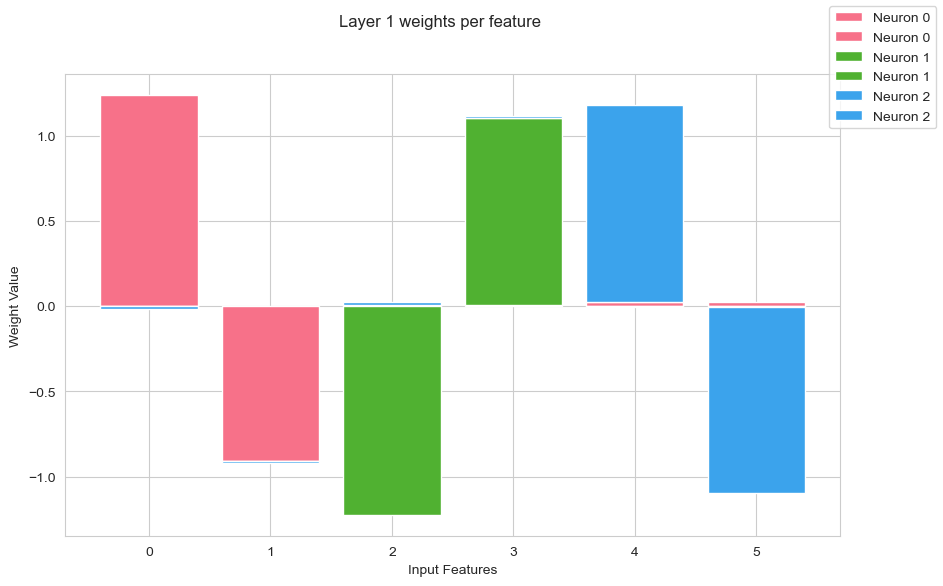

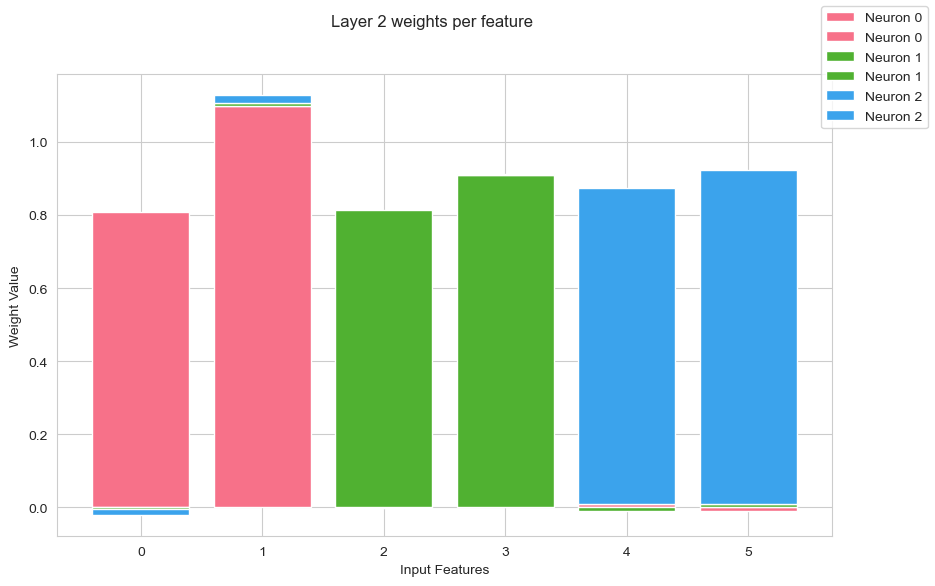

In [17]:
"""Visualize the learned weights."""

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle("Layer 1 weights per feature")
fig_w1.legend(loc="upper right")

fig_w2 = plot_weight_bars(model.W2[0].T)
fig_w2.suptitle("Layer 2 weights per feature")
fig_w2.legend(loc="upper right")

### Asymmetryic superposition + inhibition

Now, with 6 features and 10 neurons (and sparsity), computation must make use of superposition, so see if we get something that looks like this:

![10 h 6 f learned abs](./assets/cis_x6n10_learned_abs.png)

2 neuron example:

![example_asymmetric_superpos_plus_inhibition](./assets/asymmetric_superposition_plus_inhibition.png)

### (Asymmetryic superposition + inhibition) + (single-sided `abs`) ~= full computation explanation

In [20]:
"""
Create and train Anthropic TMS-CIS model with superposition, partly explained by
asymmetric superposition + inhibition
"""

# Create model
cfg = CisConfig(n_instances=1, n_feat=6, n_hidden=10, feat_sparsity=0.99, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.003816518234089017,
 0.0008540802518837154,
 0.0006827829056419432,
 0.00144657539203763,
 0.0008553704828955233,
 0.0008509808103553951,
 0.00043229738366790116,
 0.0009289132431149483,
 0.0016339486464858055,
 0.0014795357128605247,
 0.0011038124794140458]

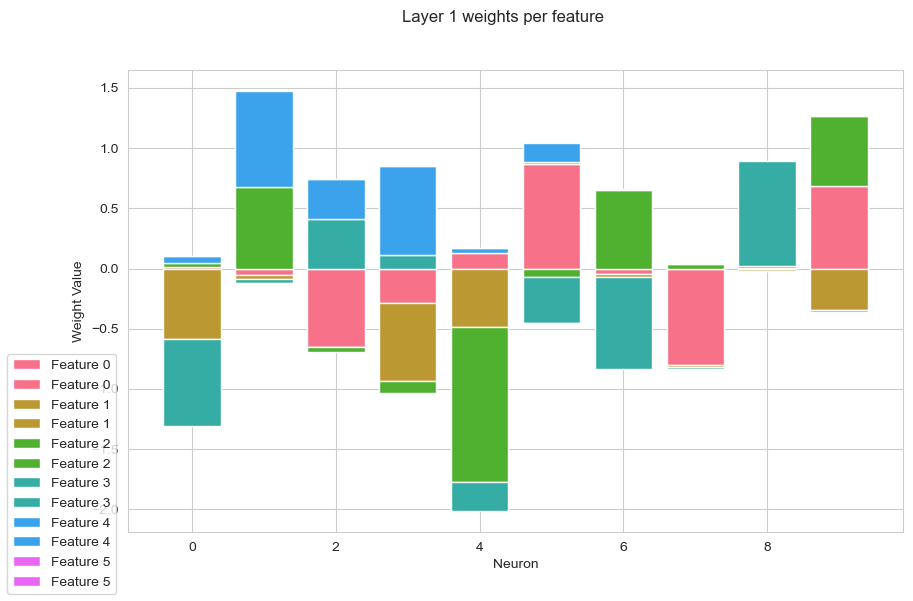

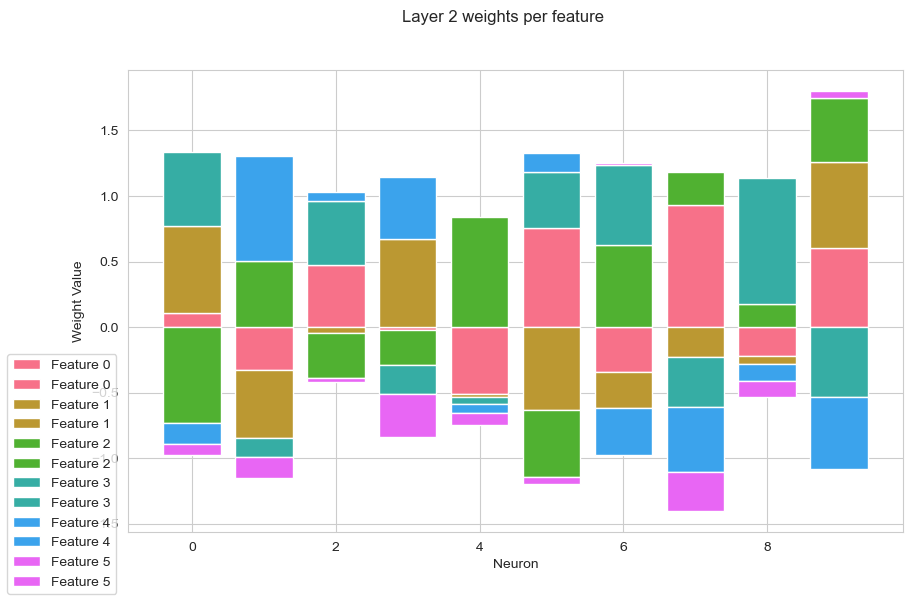

In [22]:
"""Visualize the learned weights."""

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle("Layer 1 weights per feature")
fig_w1.legend(loc='lower left')

fig_w2 = plot_weight_bars(model.W2[0].T)
fig_w2.suptitle("Layer 2 weights per feature")
fig_w2.legend(loc='lower left')

Features teal and pink in neurons 6 (asymmetric superposition) and 8 (inhibition) _loosely_ resemble asymmetric superposition + inhibition in Anthropic TMS-CIS model.

And we rarely see simple "single-sided abs" computation preserved (not at all in this training run.)

## How does polysemanticity change as a function of sparsity and importance?

Anthropic results:

![tms-cis polysemanticity](./assets/tms_cis_polysemanticity_with_importance_as_function_of_sparsity.png)

Initial thoughts: monosemanticity might be a function of feature importance alone. (In a different but similar toy model, Stefan et al observed that performance didn't change much as a function of sparsity, and that neurons are polysemantic at even low sparsity.)

### Low sparsity, equal importance

Text(0.5, 0.98, 'Layer 1 weights per feature; (1-S)=0.9')

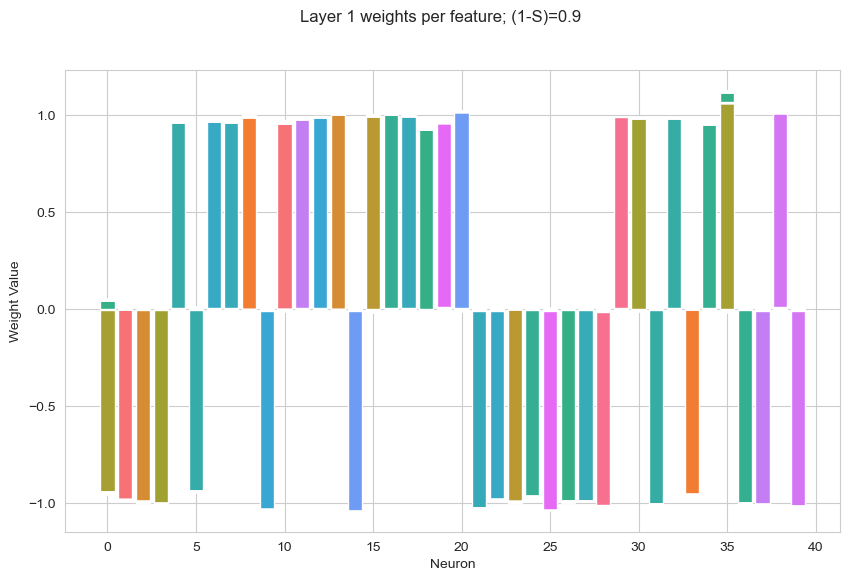

In [27]:
# Create model
S = 0.1
cfg = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=S, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle(f"Layer 1 weights per feature; {(1-S)=}")

### Some sparsity, equal importance

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.08384646475315094,
 0.06069040298461914,
 0.05624056234955788,
 0.05466920882463455,
 0.054760560393333435,
 0.05475204810500145,
 0.054114531725645065,
 0.05491672456264496,
 0.054395511746406555,
 0.05407257378101349,
 0.054608918726444244]

Text(0.5, 0.98, 'Layer 1 weights per feature; (1-S)=0.25')

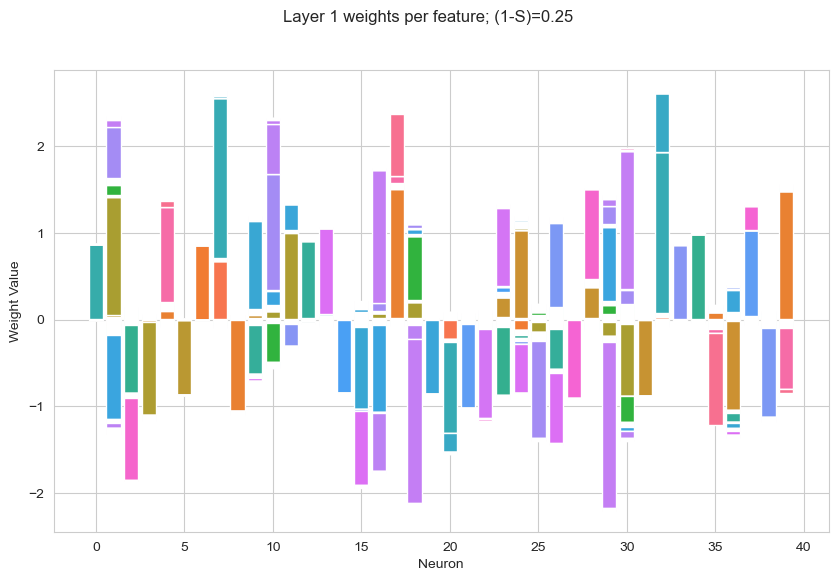

In [ ]:
# Create model
S = 0.75
cfg = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=S, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle(f"Layer 1 weights per feature; {(1-S)=}")

### High sparsity, equal importance

Text(0.5, 0.98, 'Layer 1 weights per feature; (1.0-S)=0.010000000000000009')

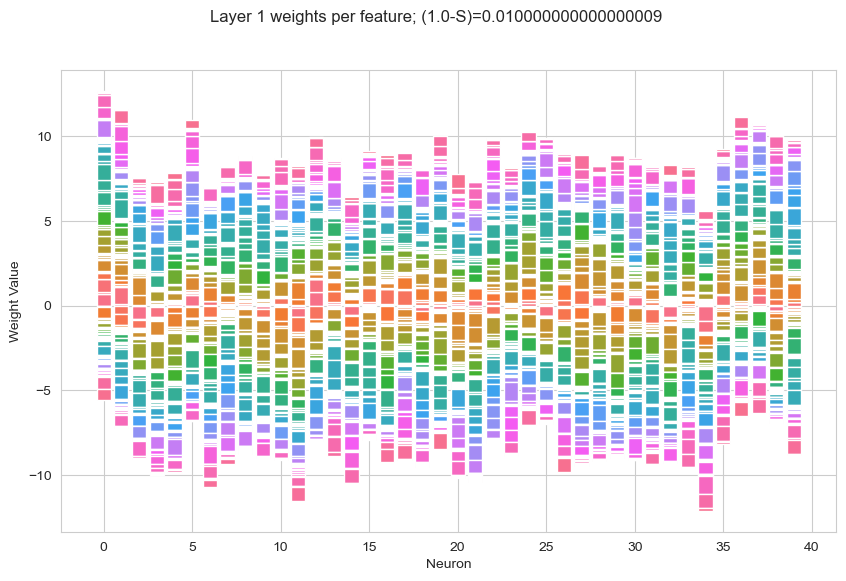

In [33]:
# Create model
S = 0.99
cfg = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=S, feat_importance=1)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle(f"Layer 1 weights per feature; {(1-S)=}")

### Polysemanticity as a function of sparsity with equal importance

![polysemanticity as a function of sparsity with equal importance](./assets/polysemanticity_as_function_of_sparsity_equal_importance.png)

### High sparsity, some relative importance

Feature importance delays onset (or reduces number) of polysemantic neurons

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.00014841683150734752,
 1.0230820407741703e-05,
 7.83245104685193e-06,
 7.495706540794345e-06,
 3.7295092170097632e-06,
 5.987667464069091e-06,
 6.055814083083533e-06,
 4.707243078883039e-06,
 5.4148963499756064e-06,
 5.1018164413108025e-06,
 2.4669539016031194e-06]

Text(0.5, 0.98, 'Layer 1 weights per feature; (1-S)=0.010000000000000009,  I=0.8^i_feat')

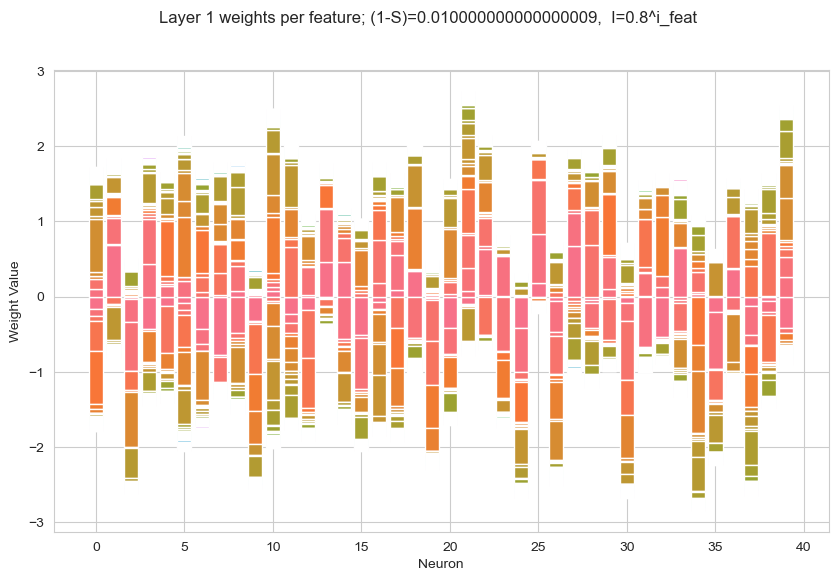

In [38]:
# Set feature importance
n_feat = 100
base = 0.8
exponents = t.arange(0, n_feat, dtype=t.float32)
I = t.pow(base, exponents)

S = 0.99
cfg = CisConfig(n_instances=1, n_feat=100, n_hidden=40, feat_sparsity=S, feat_importance=I)
model = Cis(cfg)

# Train model
optimizer = optim.Adam(model.parameters())
batch_sz = 1024
n_steps = 5000
logging_freq = n_steps // 10

losses = train(model, batch_sz, loss_fn, optimizer, n_steps, logging_freq)

display(losses)

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle(f"Layer 1 weights per feature; {(1-S)=},  I={base}^i_feat")

## Simpler, more general model of CiS: Lucius' toy model:

Target: $y = ReLU(x)$

Linear map: 

$$
h = ReLU(W_1x)
y' = W_2h + b
$$

Lucius wondered how polysemantic neurons would be in 0 importance case: i.e. how much superposition in a single neuron (1/10 features, 1/2 features, all features?) and hypothesized that each neuron would represent some small amount of features with a bit of redundant overlap (e.g. if 100 features and 40 neurons, maybe ~10 features / neuron).

We saw much more: ~ 2/5 features per neuron.

![2/5 features per neuron](./assets/heavy_superposition_lucius_toy_model.png)

## Future Directions

- Do more rigorous experiments + analysis on Anthropic + Lucius' models
- Test Apollo's model
- Better understand when polysemanticity occurs and why (e.g. why does it differ between Apollo's and Anthropic's models?)
- Show that we can explain CiS for a range of functions (e.g. ReLU, x**2, etc.) ?